In [1]:
import itertools
import numpy as np
import functools

In [2]:
%display latex

In [3]:
def same(*args):
    for arg in args:
        assert args[0] == arg
    return args[0]

# Probleme

## 1

In [4]:
class GaussQuad:
    def __init__(self, alphas, betas, wf):
        self.n = same(len(alphas), len(betas))
        
        self.wf = wf
    
        J = np.zeros((self.n, self.n))
        for k, alpha, beta in zip(range(self.n), alphas, betas):
            J[k, k] = alpha
            if k-1 >= 0:
                J[k-1, k] = sqrt(beta)
                J[k, k-1] = sqrt(beta)

        x = var("x")
        polys = [0, 1]
        for k, alpha, beta in zip(itertools.count(2), alphas, betas):
            poly = (x - alpha)*polys[k-1] - beta*polys[k-2]
            polys.append(poly)
        self.poly = polys[-1]
        self.poly = self.poly.full_simplify()
        
        # Eigenvectors are returned in normalized form.
        # eig.eigenvectors[vector_dimension,vector]
        eig = np.linalg.eig(J)
        eig_val = eig.eigenvalues
        eig_vec = eig.eigenvectors.T

        self.x = eig_val.tolist()
        v = eig_vec.tolist()

        self.w = []
        for k in range(self.n):
            self.w.append(betas[0]*v[k][0]**2)
    
    @property
    def sx(self):
        return var("x")
    
    @property
    def sf(self):
        return function("f")
    
    @functools.cached_property
    def quad(self):
        quad = 0
        for xv, wv in zip(self.x, self.w):
            quad += wv*(self.sf)(xv)
        return quad
    
    @functools.cached_property
    def poly_norm(self):
        coef = max(self.poly.coefficients(), key=lambda a: a[1])[0]
        poly = self.poly / coef
        return poly
        
    @property
    def rest(self):
        a = var("a")
        b = var("b")
        
        with assuming(a < b):
            rest = (
                diff((self.sf)(self.sx), self.sx, 2*self.n)
                / factorial(2*self.n)
                * integral(self.wf(self.sx)*self.poly_norm**2, self.sx, a, b)
            )
        return rest

In [5]:
def legendre_values(n):
    alphas = []
    betas = []
    for k in range(n):
        alphas.append(0)
        if k == 0:
            betas.append(2)
        else:
            betas.append((4-k**-2)**-1)
    
    w = function("w")
    x = var("x")
    w(x) = 1
            
    return alphas, betas, w

In [6]:
gq = GaussQuad(*legendre_values(10))
gq.quad

0.06667134430868765*f(0.9739065285171717) + 0.14945134915058084*f(0.8650633666889845) + 0.21908636251598165*f(0.6794095682990247) + 0.26926671930999635*f(0.43339539412924705) + 0.2955242247147529*f(0.14887433898163147) + 0.2955242247147521*f(-0.14887433898163108) + 0.2692667193099968*f(-0.43339539412924777) + 0.2190863625159818*f(-0.6794095682990237) + 0.1494513491505793*f(-0.8650633666889843) + 0.06667134430868907*f(-0.9739065285171716)

In [7]:
def chebyshev_values_1(n):
    alphas = []
    betas = []
    for k in range(n):
        alphas.append(0)
        if k == 0:
            betas.append(pi)
        elif k == 1:
            betas.append(1/2)
        else:
            betas.append(1/4)
            
    w = function("w")
    x = var("x")
    w(x) = (1-x**2)**(-1/2)
            
    return alphas, betas, w

In [8]:
def chebyshev_values_2(n):
    alphas = []
    betas = []
    for k in range(n):
        alphas.append(0)
        if k == 0:
            betas.append(1/2 * pi)
        else:
            betas.append(1/4)
    
    w = function("w")
    x = var("x")
    w(x) = (1-x**2)**(1/2)
    
    return alphas, betas, w

In [9]:
def jacobi_values(n, alpha, beta):
    alphas = []
    betas = []
    
    for k in range(n):
        alphas.append(
            (beta**2 - alpha**2)
            / ((2*k + alpha + beta) * (2*k + alpha + beta + 2))
        )
        
        if k == 0:
            betas.append(
                2**(alpha + beta + 1)
                * (
                    (gamma(alpha + 1)*gamma(beta + 1))
                    / (gamma(alpha + beta + 2))
                )
            )
        elif k == 1:
            betas.append(
                (
                    4
                    * (1 + alpha)
                    * (1 + beta)
                )
                / (
                    (2 + alpha + beta)**2
                    * (3 + alpha + beta)
                )
            )
        else:
            betas.append(
                (
                    4*k
                    * (k + alpha)
                    * (k + alpha + beta)
                    * (k + beta)
                )
                / (
                    (2*k + alpha + beta - 1)
                    * (2*k + alpha + beta)**2
                    * (2*k + alpha + beta + 1)
                )
            )
    
    w = function("w")
    x = var("x")
    w(x) = (1-x)**alpha * (1+x)**beta
    
    return alphas, betas, w

In [10]:
def laguerre_values(n, alpha):
    alphas = []
    betas = []
    
    for k in range(n):
        alphas.append(2*k+alpha+1)
        if k == 0:
            betas.append(gamma(1+alpha))
        else:
            betas.append(k*(k+alpha))
    
    w = function("w")
    x = var("x")
    w(x) = x**alpha * e**(-x)
    
    return alphas, betas, w

In [11]:
def hermite_values(n):
    alphas = []
    betas = []
    
    for k in range(n):
        alphas.append(0)
        if k == 0:
            betas.append(sqrt(pi))
        else:
            betas.append(1/2*k)
    
    w = function("w")
    x = var("x")
    w(x) = e**(-x**2)
    
    return alphas, betas, w

## 2

8 noduri sunt necesare

0.620536602926745

(2.2247658899910822e-18)*diff(f(x), x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x)

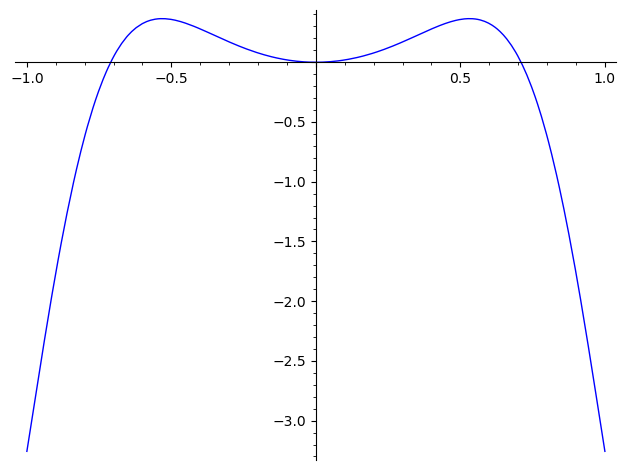

In [12]:
x = var("x")
fv = function("f")
fv(x) = sin(x**2)
gq = GaussQuad(*legendre_values(8))
quad = gq.quad.substitute_function(gq.sf, fv)
rest = gq.rest.substitute(a=-1, b=1)

pretty_print(quad)
pretty_print(rest)

rest = rest.substitute_function(gq.sf, fv)
plot(rest, -1, 1)

7 noduri sunt necesare

1.80904845936581

(2.127432382288623e-15)*diff(f(x), x, x, x, x, x, x, x, x, x, x, x, x, x, x)

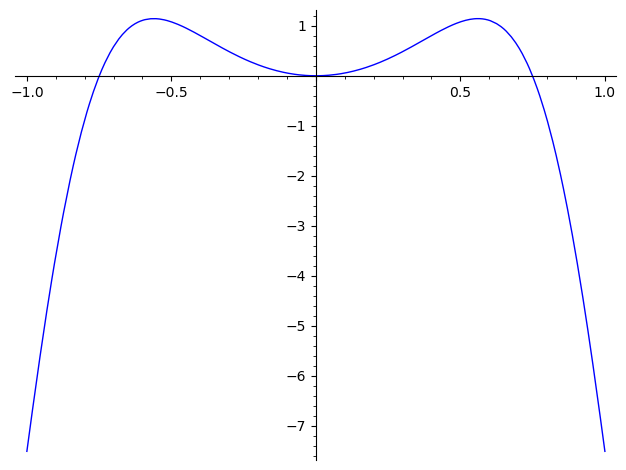

In [13]:
x = var("x")
fv = function("f")
fv(x) = cos(x**2)
gq = GaussQuad(*legendre_values(7))
quad = gq.quad.substitute_function(gq.sf, fv)
rest = gq.rest.substitute(a=-1, b=1)

display(quad)
display(rest)

rest = rest.substitute_function(gq.sf, fv)
plot(rest, -1, 1)

## 3

In [14]:
x = var("x")
f = function("f")
gq = GaussQuad(*chebyshev_values_1(10))

display(gq.quad)

fv = function("f")
fv(x) = x*e**(-x**2)
quad = gq.quad.substitute_function(f, fv)

display(quad.n())
display(integral(fv(x) / sqrt(1-x**2), x, -1, 1))

0.10000000000000049*pi*f(0.987688340595138) + 0.0999999999999993*pi*f(0.891006524188368) + 0.10000000000000003*pi*f(0.7071067811865477) + 0.09999999999999996*pi*f(0.4539904997395468) + 0.09999999999999994*pi*f(0.15643446504023098) + 0.10000000000000012*pi*f(-0.15643446504023079) + 0.10000000000000021*pi*f(-0.4539904997395472) + 0.09999999999999994*pi*f(-0.7071067811865471) + 0.09999999999999842*pi*f(-0.8910065241883673) + 0.100000000000002*pi*f(-0.9876883405951378)

-9.15565480727266e-16

0

## 4

0.0072157485076736185*pi*f(0.9594929736144974) + 0.02657204486355056*pi*f(0.8412535328311808) + 0.0519234017396947*pi*f(0.654860733945285) + 0.0752209424520584*pi*f(0.41541501300188644) + 0.08906786243702253*pi*f(0.14231483827328492) + 0.08906786243702276*pi*f(-0.14231483827328548) + 0.07522094245205838*pi*f(-0.41541501300188616) + 0.05192340173969497*pi*f(-0.6548607339452843) + 0.026572044863550047*pi*f(-0.8412535328311812) + 0.007215748507673855*pi*f(-0.9594929736144979)

1.25892425655152

1.2589242626487025

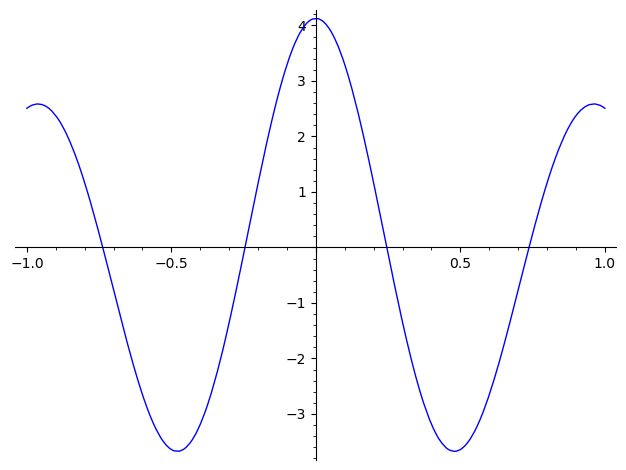

In [15]:
gq = GaussQuad(*chebyshev_values_2(10))

display(gq.quad)

x = var("x")
fv = function("f")
fv(x) = e**(-x**2)
quad = gq.quad.substitute_function(gq.sf, fv)

display(quad.n())
display(integral(fv(x) * sqrt(1-x**2), x, -1, 1).n())

rest = gq.rest.substitute(a=-1, b=1).substitute_function(gq.sf, fv)
plot(rest, -1, 1)

Valoarea maxima a restului depaseste 4. Asadar, nici prima cifra nu este corecta.

## 5

Deoarece $f(x)=\sin{x}$, inseamna ca $f^{(n)}(x)\le1,\forall x\in R, n\in N$. Aceeasi se aplica si pentru $f(x)=\cos{x}$.

In [16]:
x = var("x")
fv = function("f")
fv(x) = sin(x)
display(fv)

n = 1
while True:
    gq = GaussQuad(*laguerre_values(n, 0))

    rest = (
        1
        / factorial(2*gq.n)
        * integral(gq.wf(gq.sx)*gq.poly_norm**2, gq.sx, 0, oo)
    )
    if rest < 10**-8:
        break
    n += 1

display(n)
display(gq.quad.substitute_function(gq.sf, fv))

x |--> sin(x)

15

0.500000000204871

In [17]:
x = var("x")
fv = function("f")
fv(x) = cos(x)
display(fv)

n = 1
while True:
    gq = GaussQuad(*laguerre_values(n, 0))

    rest = (
        1
        / factorial(2*gq.n)
        * integral(gq.wf(gq.sx)*gq.poly_norm**2, gq.sx, 0, oo)
    )
    if rest < 10**-8:
        break
    n += 1

display(n)
display(gq.quad.substitute_function(gq.sf, fv))

x |--> cos(x)

15

0.499999999935132

## 6

In [18]:
x = var("x")
fv = function("f")
fv(x) = sin(x)
display(fv)
gq = GaussQuad(*hermite_values(10))
display(gq.quad.substitute_function(gq.sf, fv).n())
display(integral(fv(x)*e**(-x**2), x, -oo, oo).n())

x |--> sin(x)

8.37374035794795e-16

0.000000000000000

In [19]:
fv = function("f")
fv(x) = cos(x)
display(fv)
gq = GaussQuad(*hermite_values(10))
display(gq.quad.substitute_function(gq.sf, fv).n())
display(integral(fv(x)*e**(-x**2), x, -oo, oo).n())

x |--> cos(x)

1.38038844704314

1.38038844704314

## 7

Pentru ca $f(x)=\frac{\sqrt{2}}{\sqrt{x+3}}$, pentru $x\in[-1,1]$, orice functie $f^{(2k)}(x),k\in\mathbb{N}$ isi va atinge valoarea maxima in $x=-1$.

In [20]:
fv = function("f")
fv(x) = sqrt(2) / sqrt(3 + x)
display(fv)

x |--> sqrt(2)/sqrt(x + 3)

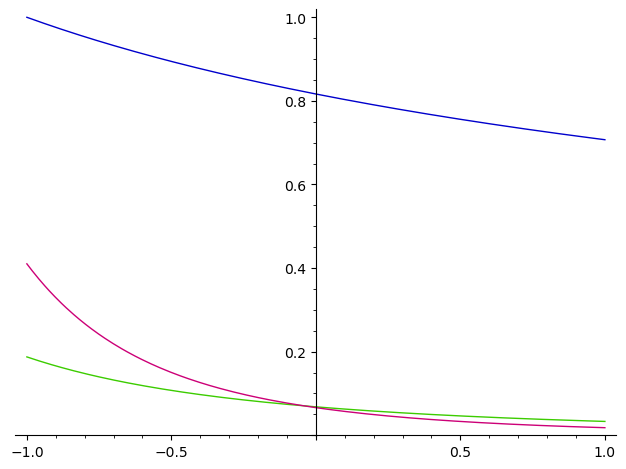

In [21]:
plot([diff(fv, x, 2*i) for i in range(3)], -1, 1)

In [22]:
n = 1
while True:
    gq = GaussQuad(*jacobi_values(n, -1/2, -1/2))
    rest = (
        diff((gq.sf)(gq.sx), gq.sx, 2*gq.n)
        / factorial(2*gq.n)
        * integral(gq.wf(gq.sx)*gq.poly_norm**2, gq.sx, -1, 1)
    )
    
    rest = rest.substitute(x=-1).substitute_function(gq.sf, fv)
    if rest < 10**-9:
        break
    n += 1

display(gq.quad.substitute_function(gq.sf, fv).n())
display(integral(1 / sqrt(sin(x)), x, 0, pi/2).n())

2.62205755429170

2.62205755429212

In [23]:
legendre_values(4)

([0, 0, 0, 0],
 [2, 0.3333333333333333, 0.26666666666666666, 0.2571428571428572],
 x |--> 1)